In [ ]:
# !pip install path
TESTING = False
bs, bptt = 32, 32
TESTING_SIZE = 100

In [ ]:
import pandas as pd
import numpy as np

# import path
import seaborn as sns
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *

import re
import utils

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
assert 'apply_functions' in dir(utils)

In [ ]:
# path= Path('.')
# path.ls()

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
train.head()
if TESTING:
    train = train.head(TESTING_SIZE)
    test = test.head(TESTING_SIZE)
    bs, bptt = 10, 10

## **Let's start the Fastai model**

we won't delete the location and keyword columns

In [ ]:
train['location'].fillna('No',inplace = True)
train['keyword'].fillna('No',inplace = True) 
test['keyword'].fillna('No',inplace = True) 
test['location'].fillna('No',inplace = True) 

In [ ]:
list_of_functions = [utils.clean, utils.remove_emoji, utils.remove_html]
train['text'] = utils.apply_functions(train['text'], list_of_functions)
test['text'] = utils.apply_functions(test['text'], list_of_functions)

In [9]:
train.head()

,id,keyword,location,text,target
0,1,No,No,our deeds are the reason of this # earthquake...,1
1,4,No,No,forest fire near la ronge sask . canada,1
2,5,No,No,all residents asked to ' shelter in place ' ...,1
3,6,No,No,"13,000 people receive # wildfires evacuation ...",1
4,7,No,No,just got sent this photo from ruby # alaska a...,1


In [ ]:
# apply tokenization and numericalization
# it basically creates a separate unit (i.e. a “token”) for each separate part of a word
#o get the data ready for a language model
# Language model data
# data_lm = TextLMDataBunch.from_df('.', train_df=train2 , valid_df=test ,text_cols = 'text', bs=48 ).split_by_rand_pct(0.1)

In [11]:
## create databunch with both train and test text and label for language model
data_fwd = (TextList.from_df(pd.concat([train[['text']], test[['text']]]), '.')
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs, bptt=bptt))
data_fwd.save('data_fwd.pkl')

In [ ]:
data_bwd = load_data('.', 'data_fwd.pkl', bs=bs, bptt=bptt, backwards=True)
data_bwd.save('data_bwd.pkl')

In [13]:
#dnld wiki103t to train model weight
learn_fwd = language_model_learner(data_fwd, AWD_LSTM, drop_mult=0.3)
# learn_fwd = learn_fwd.to_fp16(clip=0.1)

In [14]:
learn_fwd.lr_find()
#train last layer

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.63E-02


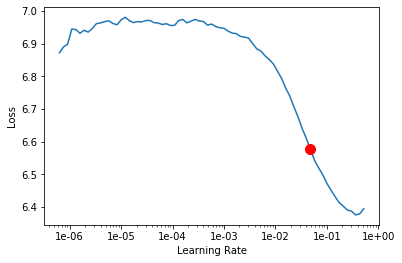

In [15]:
learn_fwd.recorder.plot(skip_end=15 ,suggestion=True)

In [16]:
# access the corresponding learning rate 
min_grad_lr = learn_fwd.recorder.min_grad_lr
min_grad_lr

0.0478630092322638

In [17]:
# just fine-tuning the last layers
learn_fwd.fit_one_cycle(2, min_grad_lr ,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.880784,4.452235,0.282227,00:07
1,3.952133,4.085771,0.325707,00:07


In [18]:
learn_fwd.unfreeze()
learn_fwd.fit_one_cycle(5, min_grad_lr/5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.693788,4.114192,0.320638,00:10
1,3.789169,4.033605,0.333194,00:11
2,3.410697,3.925064,0.352818,00:11
3,2.656323,3.939779,0.373000,00:11
4,1.824039,4.142228,0.371187,00:11


In [ ]:
## save model and encoder
learn_fwd.save('fwd_full')
learn_fwd.save_encoder('fwd_enc')

In [ ]:
learn_bwd = language_model_learner(data_bwd, AWD_LSTM, drop_mult=0.3)
# learn_bwd = learn.to_fp16(clip=0.1)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.02E-02
0.0478630092322638


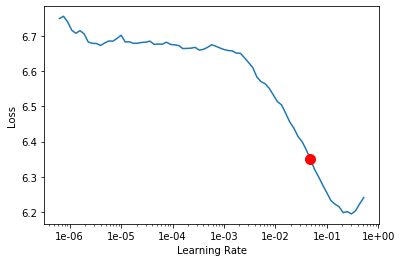

In [23]:
learn_bwd.lr_find()
learn_bwd.recorder.plot(skip_end=15 ,suggestion=True)
min_grad_lr = learn_bwd.recorder.min_grad_lr
print(min_grad_lr)

In [24]:
learn_bwd.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.637037,4.207689,0.314407,00:07


In [25]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(5, min_grad_lr/5, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.959417,4.136785,0.319475,00:11
1,3.954256,4.014396,0.340774,00:11
2,3.528982,3.868927,0.368629,00:11
3,2.819823,3.815712,0.386254,00:11
4,1.872398,3.967186,0.385649,00:11


In [ ]:
learn_bwd.save('bwd_full')
learn_bwd.save_encoder('bwd_enc')

In [27]:
data_clas_fwd = (TextList.from_df(train[['text', 'target']], '.', vocab=data_fwd.vocab)
             #.split_none()
             .split_by_rand_pct(0.1)
             .label_from_df('target')
             .add_test(TextList.from_df(test[['text']], '.', vocab=data_fwd.vocab))
#              .filter_missing_y()
             .databunch(bs=bs))
data_clas_fwd.save('data_clas_fwd')

In [28]:
data_clas_fwd.show_batch()

text,target
xxbos _ \n ? ? ? ? ? retweet \n ? ? ? ? ? ? ? \n ? ? ? ? ? follow all who rt \n ? ? ? ? ? ? ? \n ? ? ? ? ? xxunk \n ? ? ? ? ? ? ? \n ? ? ? ? ? gain with \n ? ? ?,0
xxbos when you are taking a shower and someone xxunk the toilet and you have . 1 second to xxunk or you get burned ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?,0
xxbos usgs eq : m 1 . 9 - 5 km s of volcano hawaii : time 2015 - 08 - 06 01 : 04 : 01 utc 2015 - 08 - 05 15 : 04 : 01 - 10 : 00 a . . . # earthquake,1
xxbos mom : ' we did not get home as fast as we xxunk ' \n me : ' why is that ? ' \n mom : ' there was an accident and some truck xxunk xxunk all over ? ? ? ? ? ?,0
xxbos i m dead ! ! ! my two loves in 1 photo ! my heart exploded into a million pieces ! ! ! ? ? ? ? ? ? ? ? ? ? ? ? ? ? @ xxunk @ xxunk,0


**Text classifier learner **

In [ ]:
clas_learn_fwd = text_classifier_learner(data_clas_fwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
clas_learn_fwd.load_encoder('fwd_enc')
clas_learn_fwd.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 1.74E-02


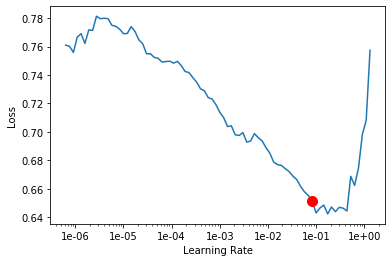

In [30]:
clas_learn_fwd.lr_find()
clas_learn_fwd.recorder.plot(suggestion=True)

In [31]:
min_grad_lr = clas_learn_fwd.recorder.min_grad_lr
print(min_grad_lr)

0.08317637711026708


In [32]:
clas_learn_fwd.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.530876,0.436481,0.804205,00:04


In [ ]:
clas_learn_fwd.freeze_to(-2)

In [34]:
clas_learn_fwd.fit_one_cycle(1, slice(1e-2/(2.6**4),min_grad_lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.494456,0.423582,0.814717,00:04


In [35]:
clas_learn_fwd.freeze_to(-3)
clas_learn_fwd.fit_one_cycle(1, slice(5e-3/(2.6**4),min_grad_lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.480611,0.413917,0.818660,00:08


In [36]:
clas_learn_fwd.unfreeze()
clas_learn_fwd.fit_one_cycle(2, slice(1e-3/(2.6**4),min_grad_lr), moms=(0.8,0.7))
clas_learn_fwd.save('fine_tuned_fwd_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.441524,0.448117,0.810775,00:10
1,0.322849,0.434123,0.806833,00:10


In [37]:
data_clas_bwd = (TextList.from_df(train[['text', 'target']], '.', vocab=data_bwd.vocab)
             #.split_none()
             .split_by_rand_pct(0.1)
             .label_from_df('target')
             .add_test(TextList.from_df(test[['text']], '.', vocab=data_bwd.vocab))
#              .filter_missing_y()
             .databunch(bs=bs))
data_clas_bwd.save('data_clas_bwd')

In [38]:
data_clas_bwd.show_batch()

text,target
xxbos _ \n ? ? ? ? ? retweet \n ? ? ? ? ? ? ? \n ? ? ? ? ? follow all who rt \n ? ? ? ? ? ? ? \n ? ? ? ? ? xxunk \n ? ? ? ? ? ? ? \n ? ? ? ? ? gain with \n ? ? ?,0
xxbos usgs eq : m 0 . 6 - 8 km xxunk of xxunk california : time 2015 - 08 - 06 01 : 26 : 24 utc 2015 - 08 - 05 18 : 26 : 24 - 07 : 0 . . . # earthquake,1
xxbos # usgs m 1 . 2 - 23 km s of xxunk palms california : time 2015 - 08 - 05 23 : 54 : 09 utc 2015 - 08 - 05 16 : 54 : 09 - 07 : 0 . . . # sm,1
xxbos # earthquake # sismo m 1 . 4 - 4 km e of xxunk california : time 2015 - 08 - 06 00 : 52 : 25 utc 2015 - 08 - 05 17 : 52 : 25 - 07 . . .,1
xxbos xxunk 0 explosion greg 2 [ top 3rd ] [ 0 out ] [ 0 balls ] [ 0 strikes ] . . . no one on [ p : # 16 morgan xxunk ] [ b : ],1


**Text classifier learner **

In [ ]:
clas_learn_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
clas_learn_bwd.load_encoder('bwd_enc')
clas_learn_bwd.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 1.74E-02


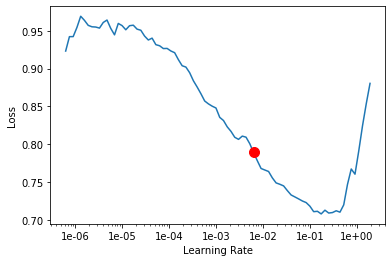

In [40]:
clas_learn_bwd.lr_find()
clas_learn_bwd.recorder.plot(suggestion=True)

In [41]:
min_grad_lr = clas_learn_bwd.recorder.min_grad_lr
print(min_grad_lr)

0.006309573444801929


In [42]:
clas_learn_bwd.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.503716,0.496903,0.762155,00:04


In [ ]:
clas_learn_bwd.freeze_to(-2)

In [44]:
clas_learn_bwd.fit_one_cycle(1, slice(1e-2/(2.6**4),min_grad_lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.469696,0.489168,0.773982,00:04


In [45]:
clas_learn_bwd.freeze_to(-3)
clas_learn_bwd.fit_one_cycle(1, slice(5e-3/(2.6**4),min_grad_lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.458377,0.475067,0.779238,00:07


In [46]:
clas_learn_bwd.unfreeze()
clas_learn_bwd.fit_one_cycle(2, slice(1e-3/(2.6**4),min_grad_lr), moms=(0.8,0.7))
clas_learn_bwd.save('fine_tuned_bwd_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.426651,0.487914,0.759527,00:10
1,0.352456,0.512173,0.776610,00:10


In [47]:
pred_fwd,lbl_fwd = clas_learn_fwd.get_preds(ds_type=DatasetType.Test, ordered=True)
pred_bwd,lbl_bwd = clas_learn_bwd.get_preds(ds_type=DatasetType.Test, ordered=True)
final_pred = (pred_fwd+pred_bwd)/2

final_pred = final_pred.argmax(dim=-1)

In [ ]:
# ## get test set predictions and ids
# preds, _ = learn.get_preds(ds_type=DatasetType.Test,  ordered=True)
# preds = preds.argmax(dim=-1)

id = test['id']

In [ ]:
my_submission = pd.DataFrame({'id': id, 'target': final_pred})
my_submission.to_csv('submission_fwd_bwd.csv', index=False)